# How to consume data from Refinitiv Data Platform (RDP) Libraries and plot data with Plotly in Jupyter Docker image.

The [jupyter/scipy-notebook](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html#jupyter-scipy-notebook) image provides the Jupyter Notebook/JupyterLab application with the [conda](https://github.com/conda/conda)/[mamba](https://github.com/mamba-org/mamba) , [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) and popular packages from the scientific Python ecosystem (Pands, Matplotlib, [Seaborn](https://seaborn.pydata.org/), etc.) for developers. What if developers need to use other Python libraries in their workbench/project?  


Developers can create a new Docker image from Jupyter Docker Stacks that contains the required libraries, and then all containers generated from the image can use the libraries without any manual installation. The Jupyter Docker Stacks let developers create own Dockerfile with with an instruction to install the Python dependencies via mamba, pip, and conda package management tools. Please see more detail on the [Using mamba install or pip install in a Child Docker image](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/recipes.html#using-mamba-install-or-pip-install-in-a-child-docker-image) page.

Firstly create a ```requirements.txt``` file in a */python/* folder with the following content:

```
plotly==5.2.2
refinitiv-dataplatform==1.0.0a10
```

Next, create a ```Dockerfile``` file in a */python/* folder with the following content:

```
# Start from a core stack version
FROM jupyter/scipy-notebook:70178b8e48d7

LABEL maintainer="Your name and email address"

# Install from requirements.txt file
COPY --chown=${NB_UID}:${NB_GID} requirements.txt /tmp/
RUN pip install --quiet --no-cache-dir --requirement /tmp/requirements.txt && \
    fix-permissions "${CONDA_DIR}" && \
    fix-permissions "/home/${NB_USER}"

ENV JUPYTER_ENABLE_LAB=yes
```

And then build a Docker image name *jupyter_rdp_plotly* with the following command:

```
docker build . -t jupyter_rdp_plotly
```
Once Docker image is built successfully, you can the following command to starts a container running a Jupyter Notebook server with all Python libraries that are defined in a ```requirements.txt``` file and  *jupyter/scipy-notebook* in your machine.

```
docker run -p 8888:8888 --name notebook -v <project /python/notebook/ directory>:/home/jovyan/work -e  --env-file .env jupyter_rdp_plotly
```
## <a id="rdp_lib"></a>Introduction to Refinitiv Data Platform (RDP) Libraries

Refinitiv provides a wide range of contents and data which require multiple technologies, delivery mechanisms, data formats, and the multiple APIs to access each content. The [RDP Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) are a suite of ease-of-use interfaces providing unified access to streaming and non-streaming data services offered within the [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis). The Libraries simplified how to access data to various delivery modes such as Request Response, Streaming, Bulk File, and Queues via a single library. 

For more deep detail regarding the RDP Libraries, please refer to the following articles and tutorials:
- [Developer Article: Discover our Refinitiv Data Platform Library part 1](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-1).
- [Developer Article: Discover our Refinitiv Data Platform Library part 2](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).
- [Refinitiv Data Platform Libraries Document: An Introduction page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/documentation).

#### Disclaimer

As this notebook has been tested on alpha versions **1.0.0.a10** of the Python library, the method signatures, data formats, etc are subject to change.

## Code Walkthrough

The application needs to import ```refinitiv.dataplatform``` and other packages in order to interact with and RDP library for Python.

In [5]:
import os

# Libraries from requirements.txt
import refinitiv.dataplatform as rdp
import plotly
import plotly.express as px

# Pre-installed with jupyter/scipy-notebook
import numpy as np
import pandas as pd

In [6]:
print('Refinitiv Data Platform Library version: ', rdp.__version__)
print('Plotly version: ', plotly.__version__)

Refinitiv Data Platform Library version:  1.0.0a10
Plotly version:  5.2.2


The RDP Libraries let application consumes data from the following platforms
- DesktopSession (Eikon/Refinitiv Workspace)
- PlatformSession (RDP, Refinitiv Real-Time Optimized)
- DeployedPlatformSession (deployed Refinitiv Real-Time/ADS)

This notebook is focusing on the *PlatformSession* only. However, the main logic for other session types are the same when interacts with the Plotly library.

In [22]:
# Open RDP Platform Session
session = rdp.open_platform_session(
    os.getenv('RDP_APP_KEY'), 
    rdp.GrantPassword(
        username = os.getenv('RDP_USER'), 
        password = os.getenv('RDP_PASSWORD')
    )
)
session.get_open_state()

<State.Open: 3>

Firstly, we will use RDP Libraries Function Layer to request time-series data as a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. 

In [23]:
# Declare parameter(s)
universe = 'TSLA.O'

In [24]:
df_historical = rdp.get_historical_price_summaries(
    universe = universe,
    interval = rdp.Intervals.DAILY,
    count = 90,
    fields = ['BID','ASK','OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']
    )
df_historical

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1
2021-04-23,729.13,729.4,719.8,737.36,715.46,729.4
2021-04-26,737.5,738,741,749.3,732.6053,738.2
2021-04-27,704.61,704.74,717.96,724,703.3501,704.74
2021-04-28,694.45,694.7,696.41,708.5,693.6,694.4
2021-04-29,677,677.03,699.51,702.25,668.5002,677
...,...,...,...,...,...,...
2021-08-24,708.32,708.48,710.68,715.22,702.64,708.49
2021-08-25,711.01,711.1,707.03,716.97,704,711.2
2021-08-26,701.15,701.16,708.31,715.4,697.6201,701.16
2021-08-27,711.65,711.9,705,715,702.1001,711.92


## <a id="plotly_intro"></a>Introduction to Plotly Python

[Plotly Python](https://plotly.com/python/) is a [free](https://plotly.com/python/is-plotly-free/) and [open source](https://github.com/plotly/plotly.py) interactive graphing library for Python. The library is built on top of [plotly.js](https://plotly.com/javascript/) JavaScript library ([GitHub](https://github.com/plotly/plotly.js)). Both Plotly Python and Plotly JavaScript are part of [Plotly](https://plotly.com/)'s Dash and Chart Studio applications suites which provide interactively, scientific data visualization libraries/solutions for Data Scientists and Enterprise. 
 
This Jupyter Notebook will focus on the Plotly Python open-source library versions **5.2.2** only. 

## <a id="plotly_express"></a>Plotly Express

The [Plotly Express](https://plotly.com/python/plotly-express/) package is the recommend entry-point to the Plotly Python library. It is the high-level interface for data visualization.  The ```plotly.express``` module (usually imported as ```px```) contains functions that can create entire figures at once and is referred to as Plotly Express or PX. Plotly Express is a built-in part of the ```plotly``` library and is the recommended starting point for creating the most common figures. 

Plotly Express provides [more than 30 functions for creating different types of figures](https://plotly.com/python-api-reference/plotly.express.html). The API for these functions was carefully designed to be as consistent and easy to learn as possible.

Firstly, we can restructure the ```df_historical``` DataFrame to make it easier to read by naming the index column to "Date"

In [25]:
df_historical.index.name = 'Date'
df_historical.head(5)

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1
Date,,,,,,
2021-04-23,729.13,729.4,719.8,737.36,715.46,729.4
2021-04-26,737.5,738,741,749.3,732.6053,738.2
2021-04-27,704.61,704.74,717.96,724,703.3501,704.74
2021-04-28,694.45,694.7,696.41,708.5,693.6,694.4
2021-04-29,677,677.03,699.51,702.25,668.5002,677


And then we change all non-Date columns data type from String to Float.

In [26]:
for column in df_historical:
    df_historical[column]=df_historical[column].astype(float)

 we change the DataFrame Date index to be a data column. This will let us plot a graph using **Date** as X-Axis.

In [27]:
df_historical.reset_index(level=0, inplace=True)
df_historical.head(5)

,Date,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1
0,2021-04-23,729.13,729.40,719.80,737.36,715.4600,729.40
1,2021-04-26,737.50,738.00,741.00,749.30,732.6053,738.20
2,2021-04-27,704.61,704.74,717.96,724.00,703.3501,704.74
3,2021-04-28,694.45,694.70,696.41,708.50,693.6000,694.40
4,2021-04-29,677.00,677.03,699.51,702.25,668.5002,677.00


Then sort data as ascending order.

In [28]:
# Sort DataFrame by Date
df_historical.sort_values('Date',ascending=True,inplace=True)

### Line Plot with Plotly Express

The [Line Plot](https://plotly.com/python/line-charts/) interface is the easy-to-use function to create a 2D line graph using ```px.line()``` function. To plot multiple lines graph, we call the ```px.line()``` function by passing a list of column names as y-axis values.

Then we use the Figure ```update_yaxes()``` method to update a figure's y-axes information.

Finally, we call the Figure ```show()``` function to draw a chart on Jupyter Notebook.

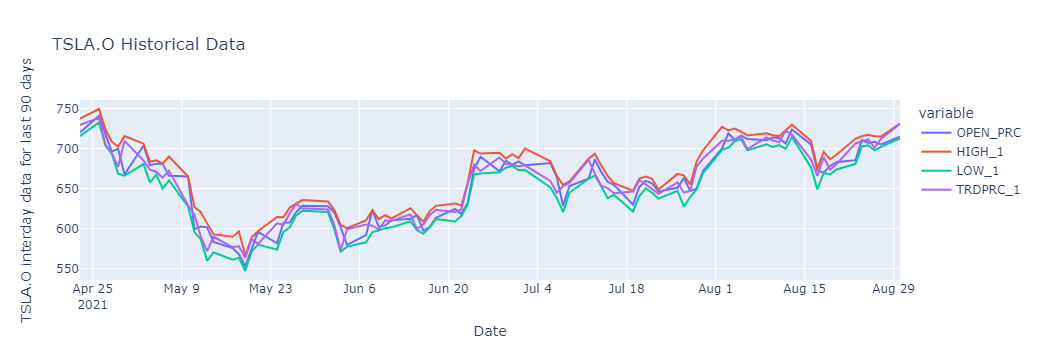

In [29]:
columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

fig = px.line(df_historical, x="Date", y=columns, title='%s Historical Data' % (universe))

fig.update_yaxes(title_text='%s interday data for last 90 days' % (universe)) #Update Y-Axis title
fig.show()

### Candlestick Chart with Plotly Graph Object

The [Plotly Graph Object](https://plotly.com/python/graph-objects/) (```plotly.graph_objects```, typically imported as ```go```) is the low-level interface that lets developers interact with Plotly Figure and IPYWidgets compatible for plotting graphs and manage data in detail. While the Plotly Express provides a simple way to create and customize graphs, the Plotly Graph Object lets developers create and customize more advanced graphs such as Group Bar Chart, Candlestick, Subplot of different types, etc. 

In [30]:
# Import plotly.graph_objects module

import plotly.graph_objects as go

This notebook demonstrates the Plotly Graph Object with the [Candlestick](https://plotly.com/python/candlestick-charts/) charts using the ```go.Candlestick``` object to create the candlestick chart from Dataframe, and pass it to ```go.Figure``` to create a Plotly Figure object to plot a graph.

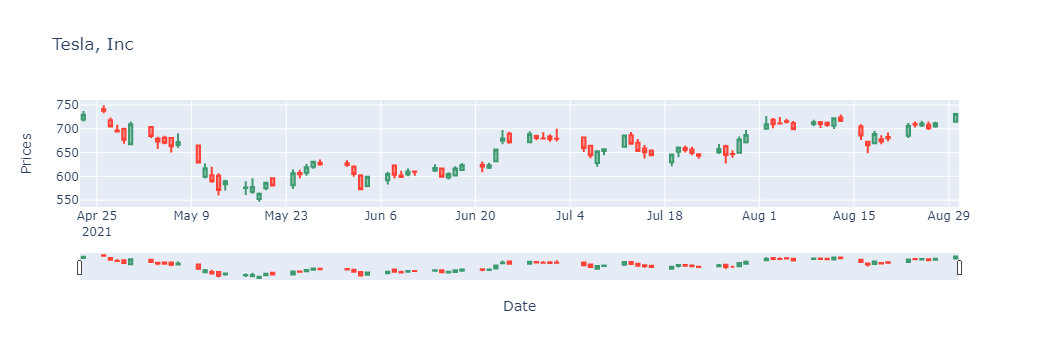

In [32]:
fig = go.Figure(data=[go.Candlestick(x=df_historical['Date'],
                open=df_historical['OPEN_PRC'],
                high=df_historical['HIGH_1'],
                low=df_historical['LOW_1'],
                close=df_historical['TRDPRC_1'])])

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Prices')
fig.update_layout(xaxis_rangeslider_visible=True, # Set Range Slider Bar
                 title = 'Tesla, Inc') # Set Title
fig.show()

## Conclusion

The jupyter/scipy-notebook image provides Jupyter Server with a handful of libraries for Data Science/Financial development works. However, if developers need additionally library, Jupyter Docker Stacks let developers create own Dockerfile with with an instruction to install the Python dependencies via mamba, pip, and conda package management tools. All containers generated from the customize image can use the libraries without any manual installation. 

## <a id="references"></a>References

You can find more details regarding the Refinitiv Data Platform Libraries, Plotly, Jupyter Docker Stacks, and related technologies for this notebook from the following resources:
* [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) website.
* [RDP Libraries Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start).
* [RDP Libraries Tutorial page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/tutorials).
* [Discover our Refinitiv Data Platform Library (part 1)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-1).
* [Discover our Refinitiv Data Platform Library (part 2)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).
* [Plotly Official page](https://plotly.com/).
* [Plotly Python page](https://plotly.com/python/).
* [Plotly Express page](https://plotly.com/python/plotly-express/)
* [Plotly Graph Objects page](https://plotly.com/python/graph-objects/)
* [Jupyter Dokcer Stacks page](https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html)
* [Jupyter Dokcer Stack on DockerHub](https://hub.docker.com/u/jupyter) website

For any questions related to Refinitiv Data Platform or Refinitiv Data Platform Libraries, please use the following forums on the [the Developers Community Q&A page](https://community.developers.refinitiv.com/).
- [RDP APIs Forum](https://community.developers.refinitiv.com/spaces/231/index.html).
- [Refinitiv Data Platform Libraries Forum](https://community.developers.refinitiv.com/spaces/321/refinitiv-data-platform-libraries.html).